# Linear Optimal Control Problem

Dynamics: $x+ = Ax+Bu$

Stage cost: $l(u,x)= u^2+x^2$

Approximate finite horizon $K$ cost: $J(x_0,u) = \sum_{k=0}^{K-1} (x_k^Tq x_k + u_k^Tr u_k)$

Value function: $V(k,x_0) = \min_{u(.)} \sum_{i=k}^{K-1} (x_i^Tq x_i + u_i^Tr u_i) $

Dynamic programming principle: $V(k,x_0) = \min_{u} \big(x_0^T q x_0 + u^T r u + V(k+1,Ax_0+Bu)\big)$


** Goal ** Estimate value function $V$ for given initial state $x$. From that we can easily find input sequence that attains the minial cost.

In [818]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
%matplotlib inline

## Data

In [819]:
A,B,q,r = 2,1,1,1

In [820]:
nbgp = 31;
nbip = 61;

In [821]:
x = np.linspace(-4,4,nbgp);
u = np.linspace(-10,10,nbip);

## 1. Solution via discrete-time Riccati Equation

**Core Assumption (only true for linear system and quadratic cost)**

$V(k+1,x_0) = x_0^TP(k+1)x_0$. 

Then,

$V(k,x_0) = \min_u \big(x_0^Tqx_0 + u^Tru +(Ax_0+Bu)^T P(k+1)(Ax_0+Bu)\Big)$.

Solving the quadratic optimization problem results in:

$u* = -(r+B^TP(k+1)B)^{-1}B^TP(k+1)Ax_0$.

Thus,

$V(k,x_0) = x_0^T\Bigg(q+A^TP(k+1)A-A^TP(k+1)B(r+B^TP(k+1)B)^{-1}B^TP(k+1)A\Bigg)x_0 = x_0^TP(k)x_0$

so

$P(k) = q+A^TP(k+1)A-A^TP(k+1)B(r+B^TP(k+1)B)^{-1}B^TP(k+1)A$


this equation is discrete-time Riccati equation which can be solved by initilizing $P(k+1)$ and recursively calculating $P(k)$.


In [822]:
def lqr_are(K,PK,A,B,r,q):
    P = np.zeros(K+1)
    P[K] = PK
    for i in range(K-1,-1,-1):
        P[i]=q+ A*P[i+1]*A - A*P[i+1]*B*1/(r + B*P[i+1]*B)*B*P[i+1]*A;
    return P

In [823]:
# Horizon
K = 20
# initialization at max time K
PK =10
P = lqr_are(K,PK,A,B,r,q)

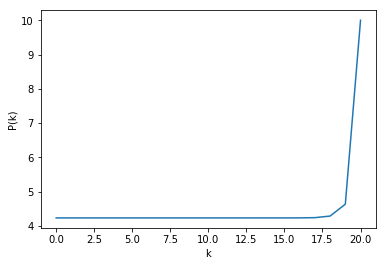

In [824]:
k = range(K+1)
plt.plot(k, P)
plt.xlabel('k')
plt.ylabel('P(k)')

Value function now is simply:

$V(k,x) = x^TP_{0} x$

where $P_0$ is value of $P$ calculated at time k=0.

In [825]:
V = np.zeros(len(x))
for i in range(len(x)):
    V[i] = x[i]*P[0]*x[i]

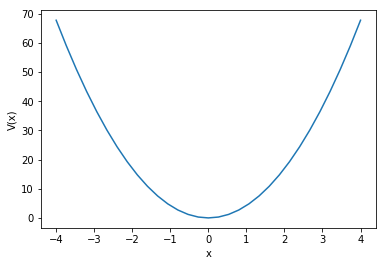

In [826]:
plt.plot(x, V)
plt.xlabel('x')
plt.ylabel('V(x)')

### Initialize different P(K) at the max time K

Let's see how the soltion behaves with different inilialized values.

In [827]:
def lqr_are(K,PK,A,B,r,q):
    P = np.zeros(K+1)
    P[K] = PK
    for i in list(range(K-1,-1,-1)):
        P[i]=q+ A*P[i+1]*A - A*P[i+1]*B*1/(r + B*P[i+1]*B)*B*P[i+1]*A;
    return P

In [828]:
P1 = lqr_are(K,1,A,B,r,q)
P2 = lqr_are(K,5,A,B,r,q)
P3 = lqr_are(K,10,A,B,r,q)
P4 = lqr_are(K,15,A,B,r,q)

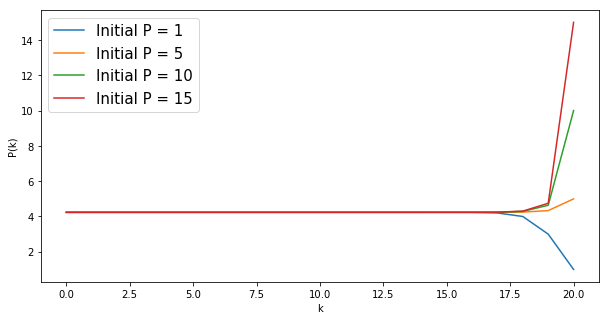

In [829]:
k = list(range(K+1))
plt.figure(figsize=(10,5)) 
plt.plot(k, P1,label="Initial P = 1")
plt.plot(k, P2,label="Initial P = 5")
plt.plot(k, P3,label="Initial P = 10")
plt.plot(k, P4,label="Initial P = 15")
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend(loc='upper left',prop={'size':15})

## 2. Approximate solution via dynamic programming

Core idea: Approximate the infinite series by a finite sum with a maximnum time index $K$.

Algorithms:

1. build a grid of state $x$ and time horizon $K$. 
2. initialize value function to be zero entire grid
3. recursively from K to 1:
   - calculate, for each grid node at layer k, the next value of state by the dynamic equation,i.e., x+
   - interpolate to get the value function at x+, i.e., V(x+)
   - calculate value function at previous layer k-1 by Bellman equation


Remmember Bellman equation:

$V(k,x_0) = \min_u \Big(loss(x,u) + V\big(k+1,f(x,u)\big)\Big)$.


In [830]:
# loss per step function
def loss(u,x,q,r):
    return q*np.array(x)**2+r*np.array(u)**2

In [831]:
def DP_LQR(K,VK,A,B,q,r):
    W = np.zeros([nbgp,K+1]) # Value grid
    W[:,K] = VK # Initialize value function at K 
    for i in list(range(K-1,-1,-1)):
        for j in range(len(x)):
            xp = A*x[j]+B*u;
            vi = np.interp(xp,x,W[:,i+1])
            W[j,i] = min(loss(x[j],u,q,r)+vi)   
    return W[:,0]

In [832]:
# Different horizons
V_dp_2 = DP_LQR(2,0,A,B,q,r)
V_dp_5 = DP_LQR(5,0,A,B,q,r)
V_dp_20 = DP_LQR(20,0,A,B,q,r)

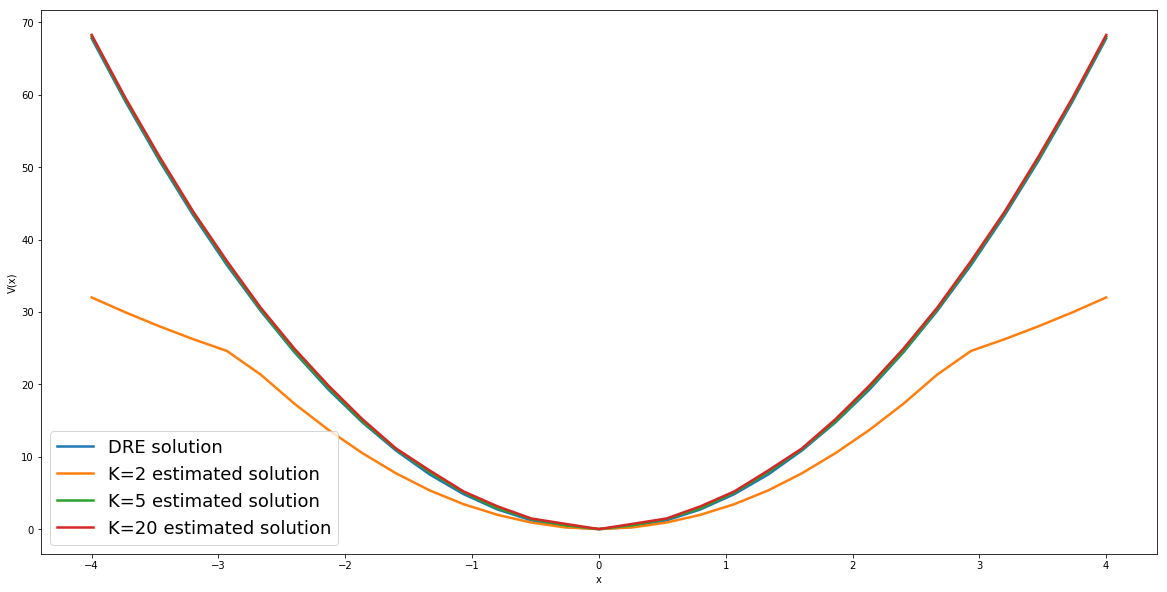

In [833]:
plt.figure(figsize=(20,10)) 
plt.plot(x, V,linewidth=2.5,label="DRE solution")
plt.plot(x, V_dp_2,linewidth=2.5,label="K=2 estimated solution")
plt.plot(x, V_dp_5,linewidth=2.5,label="K=5 estimated solution")
plt.plot(x, V_dp_20,linewidth=2.5,label="K=20 estimated solution")
plt.xlabel('x')
plt.ylabel('V(x)')
plt.legend(loc='lower left',prop={'size':18})

# V evolving on the grid of x and K

In [868]:
def DP_LQR_V(K,VK,A,B,q,r):
    W = np.zeros([nbgp,K+1]) # Value grid
    W[:,K] = VK # Initialize value function at K 
    for i in list(range(K-1,-1,-1)):
        for j in range(len(x)):
            xp = A*x[j]+B*u;
            vi = np.interp(xp,x,W[:,i+1])
            W[j,i] = min(loss(x[j],u,q,r)+vi)   
    return W

In [869]:
W = DP_LQR_V(K,0,A,B,q,r)

In [870]:
X, Y = np.meshgrid(range(K+1),x)

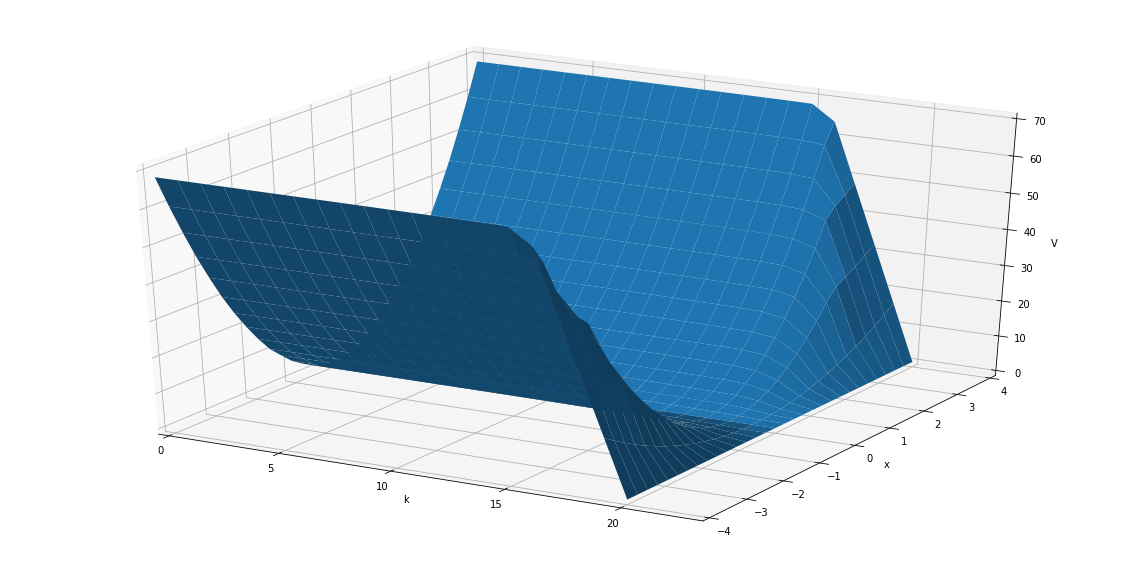

In [873]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, W)

ax.set_xlim(0,K+3)
ax.set_ylim(-4, 4)
ax.set_zlim(0, 70)

ax.set_xlabel('k')
ax.set_ylabel('x')
ax.set_zlabel('V')